## Generating Benchmark Data for M5

The data is taken from the [M5 Forecasting - Accuracy](https://www.kaggle.com/c/m5-forecasting-accuracy) challenge on Kaggle, a competiton organized by The Makridakis Open Forecasting Center (MOFC) at the University of Nicosia ($50,000).

In [3]:
ROOT = "/Users/liaopeiyuan/Documents/"
data_dir = ROOT + "m5-forecasting-accuracy/"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from tqdm import tqdm

/opt/anaconda3/envs/test/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv(data_dir + 'sales_train_evaluation.csv').fillna(0)
df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [6]:
import collections
collections.Counter(df['dept_id'].values), \
collections.Counter(df['cat_id'].values), \
collections.Counter(df['store_id'].values), \
collections.Counter(df['state_id'].values)

(Counter({'HOBBIES_1': 4160,
          'HOBBIES_2': 1490,
          'HOUSEHOLD_1': 5320,
          'HOUSEHOLD_2': 5150,
          'FOODS_1': 2160,
          'FOODS_2': 3980,
          'FOODS_3': 8230}),
 Counter({'HOBBIES': 5650, 'HOUSEHOLD': 10470, 'FOODS': 14370}),
 Counter({'CA_1': 3049,
          'CA_2': 3049,
          'CA_3': 3049,
          'CA_4': 3049,
          'TX_1': 3049,
          'TX_2': 3049,
          'TX_3': 3049,
          'WI_1': 3049,
          'WI_2': 3049,
          'WI_3': 3049}),
 Counter({'CA': 12196, 'TX': 9147, 'WI': 9147}))

Forecasting is done on a separate file. Here's what it roughly looks like.

```python
import dask.dataframe as dd

ddf = dd.from_pandas(df, npartitions=120) # over-subscribing

forecast_horizon = 100

def predict(row):
    data = pd.DataFrame({'ds': (row.index)[1:][-forecast_horizon:], 'y':(row.values)[1:][-forecast_horizon:]})
    m = Prophet()
    m.fit(data)
    
    future = m.make_future_dataframe(periods=forecast_horizon)
    future.tail()
    forecast = m.predict(future)

    return row.Page, forecast[['yhat']][-forecast_horizon:].values.reshape(-1)
```

### Sanity check by plotting

In [8]:
import pickle
predictions = pickle.load(open(data_dir + 'm5_prediction_raw/result_m5.pkl', 'rb'))

ValueError: Could not interpret value `O` for parameter `y`

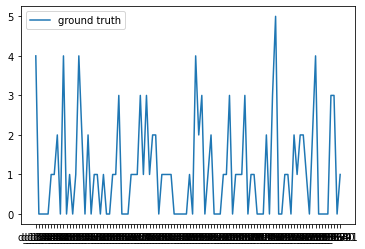

In [9]:
import seaborn as sns

def smape(a, f):
    return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

pred = predictions[0][1]
index = list(df.columns)[1:][-100:]
gt = df.iloc[0,:].values[-100:]

sns.lineplot(x=index, y=gt, label='ground truth')
sns.lineplot(x=index, y=pred, label='prediction')

print("SMAPE: ", smape(gt, pred).round(3))

### Export trace for benchmarking 

In [51]:
time_index = index
disagg = []

for p, (i, g) in tqdm(zip(predictions, df.iterrows()), total = len(df)):
    assert(p[0] == g.Page)
    disagg.append((g.Page, p[1], g.values[-100:]))

100%|███████████████████████████████████████| 145063/145063 [00:11<00:00, 13174.18it/s]


In [57]:
node_id_mapping = {'node_id': [], 'name': []}

pred_tensor = np.zeros((len(disagg), 100))
gt_tensor = np.zeros((len(disagg), 100))

for i, (name, prediction, gt) in tqdm(enumerate(disagg)):
    pred_tensor[i, :] = prediction
    gt_tensor[i, :] = gt
    node_id_mapping['node_id'].append(i)
    node_id_mapping['name'].append(name)

145063it [00:01, 112599.78it/s]


### Compiling the hierarchies

In [65]:
node_id_map_df = pd.DataFrame(node_id_mapping)

In [73]:
node_id_map_df['level_4'] = node_id_map_df['name']
node_id_map_df['level_3'] = node_id_map_df['name'].apply(lambda x: '_'.join(x.split('_')[:-1]))
node_id_map_df['level_2'] = node_id_map_df['name'].apply(lambda x: '_'.join(x.split('_')[:-2]))
node_id_map_df['level_1'] = node_id_map_df['name'].apply(lambda x: x.split('_')[-3])

In [75]:
parent_node_mapping = {'node_id': [], 'name': []}

level3 = list(set(node_id_map_df['level_3'].values))
level2 = list(set(node_id_map_df['level_2'].values))
level1 = list(set(node_id_map_df['level_1'].values))

curr_sum = len(node_id_map_df)

for s in [level3, level2, level1]:
    for i, v in enumerate(s):
        parent_node_mapping['node_id'].append(i + curr_sum)
        parent_node_mapping['name'].append(v)
    curr_sum += len(s)

In [77]:
parent_node_mapping_df = pd.DataFrame(parent_node_mapping)

In [79]:
node_id_map_df.to_csv(data_dir + 'wikipedia_time_series_prediction_raw/node_id_map.csv', index=False)
parent_node_mapping_df.to_csv(data_dir + 'wikipedia_time_series_prediction_raw/parent_node_id_map.csv', index=False)

In [80]:
np.save(open(data_dir + 'wikipedia_time_series_prediction_raw/pred_tensor.npy', 'wb'), pred_tensor)
np.save(open(data_dir + 'wikipedia_time_series_prediction_raw/gt_tensor.npy', 'wb'), gt_tensor)